In [1]:
# Cell 1: Install and import required packages
!pip install transformers timm scikit-learn seaborn

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import ViTModel

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-11-12 19:16:39.180702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762974999.203735     688 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762974999.210733     688 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [2]:
# Cell 2: Explore the dataset structure
def analyze_dataset_structure():
    base_path = "/kaggle/input/breakhis"
    benign_count = 0
    malignant_count = 0
    magnifications = set()
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                path_parts = root.split(os.sep)
                # Count by class
                if 'benign' in path_parts:
                    benign_count += 1
                elif 'malignant' in path_parts:
                    malignant_count += 1
                
                # Check magnification
                for mag in ['40X', '100X', '200X', '400X']:
                    if mag in path_parts:
                        magnifications.add(mag)
    
    print(f"Total Benign images: {benign_count}")
    print(f"Total Malignant images: {malignant_count}")
    print(f"Total images: {benign_count + malignant_count}")
    print(f"Available magnifications: {sorted(magnifications)}")
    
    return benign_count, malignant_count

benign_count, malignant_count = analyze_dataset_structure()

Total Benign images: 2480
Total Malignant images: 5429
Total images: 7909
Available magnifications: ['100X', '200X', '400X', '40X']


In [4]:
# Cell 3: Custom Dataset Class
class BreakHisDataset(Dataset):
    def __init__(self, root_dir, transform=None, magnifications=['40X', '100X', '200X', '400X']):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Class mapping
        self.class_to_idx = {'benign': 0, 'malignant': 1}
        self.idx_to_class = {0: 'Benign', 1: 'Malignant'}
        
        print("Loading BreakHis dataset...")
        
        # Base path for the dataset
        base_path = os.path.join(root_dir, "BreaKHis_v1", "BreaKHis_v1", "histology_slides", "breast")
        
        # Load benign images
        benign_path = os.path.join(base_path, "benign", "SOB")
        malignant_path = os.path.join(base_path, "malignant", "SOB")
        
        self._load_images_from_path(benign_path, 0, magnifications)
        self._load_images_from_path(malignant_path, 1, magnifications)
        
        print(f"Loaded {len(self.samples)} images")
        print(f"Class distribution: Benign: {sum(1 for s in self.samples if s['label'] == 0)}, "
              f"Malignant: {sum(1 for s in self.samples if s['label'] == 1)}")
    
    def _load_images_from_path(self, base_path, label, magnifications):
        """Recursively load images from the nested directory structure"""
        if not os.path.exists(base_path):
            print(f"Path does not exist: {base_path}")
            return
            
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    # Check if this file is in one of our desired magnifications
                    path_parts = root.split(os.sep)
                    has_desired_mag = any(mag in path_parts for mag in magnifications)
                    
                    if has_desired_mag:
                        img_path = os.path.join(root, file)
                        self.samples.append({
                            'image_path': img_path,
                            'label': label,
                            'class_name': self.idx_to_class[label],
                            'magnification': next((mag for mag in magnifications if mag in path_parts), 'unknown')
                        })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        try:
            # Load image
            image = Image.open(sample['image_path']).convert('RGB')
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
            
            label = sample['label']
            return image, label
            
        except Exception as e:
            print(f"Error loading image {sample['image_path']}: {e}")
            # Return a placeholder image if there's an error
            placeholder = torch.zeros(3, 224, 224)
            return placeholder, sample['label']
    
    def get_class_distribution(self):
        labels = [s['label'] for s in self.samples]
        return pd.Series(labels).value_counts().sort_index()
    
    def display_samples(self, num_samples=8):
        """Display sample images from the dataset"""
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        for i in range(min(num_samples, len(self.samples))):
            img, label = self[i]
            ax = axes[i//4, i%4]
            
            # Denormalize for display
            if isinstance(img, torch.Tensor):
                img_display = img.permute(1, 2, 0).numpy()
                img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img_display = np.clip(img_display, 0, 1)
            else:
                img_display = np.array(img)
            
            ax.imshow(img_display)
            ax.set_title(f"{self.idx_to_class[label]} ({self.samples[i]['magnification']})")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [5]:
# Cell 4: Adaptive Vision Transformer Model
class AdaptiveViTForBreastCancer(nn.Module):
    def __init__(self, num_classes=2, pretrained_model='google/vit-base-patch16-224-in21k',
                 keep_rates=[1.0, 0.8, 0.6, 0.5]):
        super(AdaptiveViTForBreastCancer, self).__init__()
        
        # Load pre-trained ViT
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.config = self.vit.config
        self.hidden_size = self.config.hidden_size
        
        # Adaptive parameters
        self.keep_rates = keep_rates
        
        # Token importance predictors
        self.token_predictors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden_size, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()
            ) for _ in range(len(keep_rates))
        ])
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        print(f"Adaptive ViT initialized with keep rates: {keep_rates}")
        
    def dynamic_token_selection(self, hidden_states, layer_idx):
        """Select most important tokens dynamically"""
        batch_size, num_tokens, hidden_dim = hidden_states.shape
        
        # Predict importance scores
        importance_scores = self.token_predictors[layer_idx](
            hidden_states.reshape(-1, hidden_dim)
        ).reshape(batch_size, num_tokens)
        
        # Number of tokens to keep
        num_keep = max(1, int(self.keep_rates[layer_idx] * num_tokens))
        
        # Select top-k tokens
        _, keep_indices = torch.topk(importance_scores, num_keep, dim=1)
        
        # Gather kept tokens
        kept_tokens = torch.gather(
            hidden_states, 
            1, 
            keep_indices.unsqueeze(-1).expand(-1, -1, hidden_dim)
        )
        
        return kept_tokens, importance_scores
    
    def forward(self, pixel_values, return_metrics=False):
        # Get embeddings
        embedding_output = self.vit.embeddings(pixel_values)
        hidden_states = embedding_output
        
        metrics = {
            'original_tokens': embedding_output.shape[1],
            'final_tokens': None,
            'computational_saving': 0.0
        }
        
        # Process through transformer layers with adaptive token selection
        for layer_idx, layer in enumerate(self.vit.encoder.layer):
            # Apply token selection at specific layers
            if layer_idx < len(self.keep_rates) and layer_idx > 0:
                hidden_states, importance_scores = self.dynamic_token_selection(hidden_states, layer_idx)
            
            # Standard transformer layer
            layer_outputs = layer(hidden_states)
            hidden_states = layer_outputs[0]
        
        metrics['final_tokens'] = hidden_states.shape[1]
        metrics['computational_saving'] = 1.0 - (metrics['final_tokens'] / metrics['original_tokens']) ** 2
        
        # Use CLS token for classification
        cls_token = hidden_states[:, 0]
        logits = self.classifier(cls_token)
        
        if return_metrics:
            return logits, metrics
        
        return logits

In [6]:
# Cell 5: Data Preparation (SIMPLE FIX)
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Load dataset once
print("Loading dataset...")
full_dataset = BreakHisDataset(
    root_dir="/kaggle/input/breakhis",
    transform=None,  # No transform initially
    magnifications=['40X', '100X', '200X', '400X']
)

# Split indices
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=[s['label'] for s in full_dataset.samples]
)

# Create custom dataset class that applies transform
class TransformDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        data, label = self.dataset[self.indices[idx]]
        if self.transform:
            data = self.transform(data)
        return data, label

# Create train and val datasets with proper transforms
train_dataset = TransformDataset(full_dataset, train_indices, transform=train_transform)
val_dataset = TransformDataset(full_dataset, val_indices, transform=val_transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Train/Val ratio: {len(train_dataset)/len(full_dataset):.2f}/{len(val_dataset)/len(full_dataset):.2f}")

Loading dataset...
Loading BreakHis dataset...
Loaded 7909 images
Class distribution: Benign: 2480, Malignant: 5429

Training samples: 6327
Validation samples: 1582
Batch size: 16
Train/Val ratio: 0.80/0.20


In [8]:
# Cell 6: Training Setup and Training Loop
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Move model to device
    model = model.to(device)
    
    # Training history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Calculate training accuracy and loss
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate validation accuracy and loss
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Update learning rate
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'model': model
    }

In [9]:
# Cell 7: Create Model and Start Training
# Create model instance
model = AdaptiveViTForBreastCancer(num_classes=2, keep_rates=[1.0, 0.8, 0.6, 0.5])
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Train the model
training_results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=1e-4
)

Adaptive ViT initialized with keep rates: [1.0, 0.8, 0.6, 0.5]
Total parameters: 87,704,838
Trainable parameters: 87,704,838
Starting training...
Epoch [1/10], Step [0/396], Loss: 0.6753
Epoch [1/10], Step [50/396], Loss: 0.1935
Epoch [1/10], Step [100/396], Loss: 0.1687
Epoch [1/10], Step [150/396], Loss: 0.3490
Epoch [1/10], Step [200/396], Loss: 0.4570
Epoch [1/10], Step [250/396], Loss: 0.1734
Epoch [1/10], Step [300/396], Loss: 0.3137
Epoch [1/10], Step [350/396], Loss: 0.3647
Epoch [1/10]
Train Loss: 0.3878, Train Acc: 84.42%
Val Loss: 0.2830, Val Acc: 90.64%
--------------------------------------------------
Epoch [2/10], Step [0/396], Loss: 0.2447
Epoch [2/10], Step [50/396], Loss: 0.2733
Epoch [2/10], Step [100/396], Loss: 0.4017
Epoch [2/10], Step [150/396], Loss: 0.4089
Epoch [2/10], Step [200/396], Loss: 0.1536
Epoch [2/10], Step [250/396], Loss: 0.7908
Epoch [2/10], Step [300/396], Loss: 0.0373
Epoch [2/10], Step [350/396], Loss: 0.2936
Epoch [2/10]
Train Loss: 0.2744, Tra

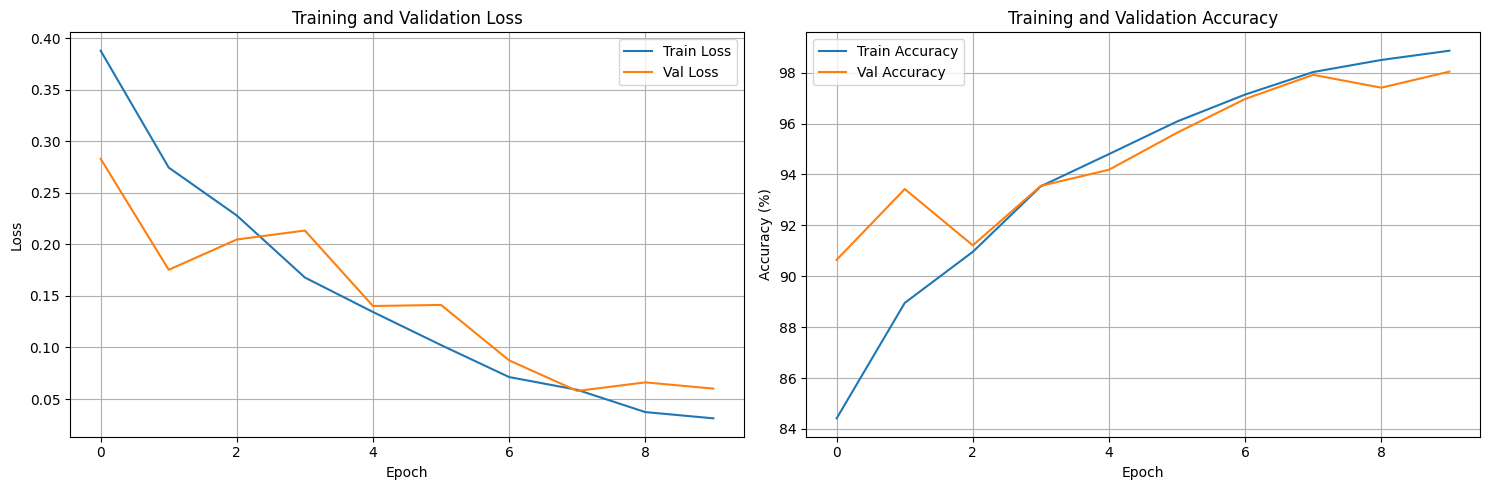

In [10]:
# Cell 8: Plot Training Results
def plot_training_results(training_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(training_results['train_losses'], label='Train Loss')
    ax1.plot(training_results['val_losses'], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(training_results['train_accuracies'], label='Train Accuracy')
    ax2.plot(training_results['val_accuracies'], label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_results(training_results)

Final Validation Accuracy: 0.9804

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97       496
   Malignant       0.98      0.99      0.99      1086

    accuracy                           0.98      1582
   macro avg       0.98      0.97      0.98      1582
weighted avg       0.98      0.98      0.98      1582



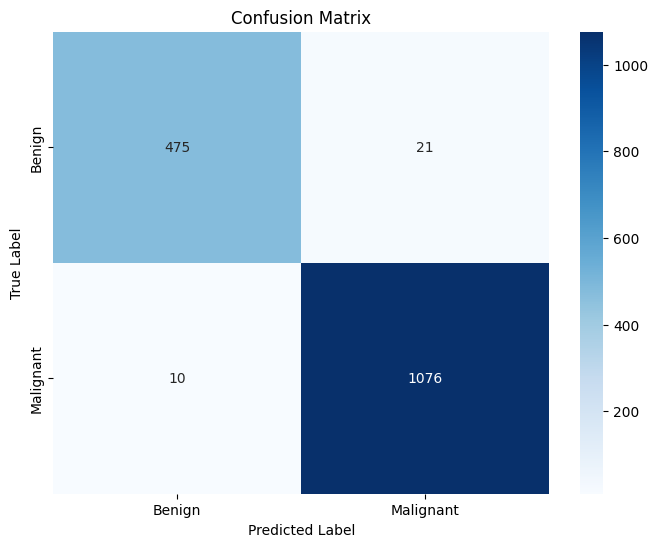

In [11]:
# Cell 9: Detailed Evaluation
def evaluate_model(model, val_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return all_predictions, all_labels, all_probabilities

# Perform detailed evaluation
predictions, true_labels, probabilities = evaluate_model(training_results['model'], val_loader)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Final Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Benign', 'Malignant']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# Cell 10: Save the Model
def save_model(model, filepath):
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_results': training_results
    }, filepath)
    print(f"Model saved to {filepath}")

# Save the trained model
save_model(training_results['model'], 'breast_cancer_vit_model.pth')

print("\nTraining completed! Check the validation accuracy and confusion matrix above.")
print("If validation accuracy is significantly lower than training accuracy, you might be overfitting.")
print("Consider: more data augmentation, regularization, or early stopping.")

Model saved to breast_cancer_vit_model.pth

Training completed! Check the validation accuracy and confusion matrix above.
If validation accuracy is significantly lower than training accuracy, you might be overfitting.
Consider: more data augmentation, regularization, or early stopping.
